# 0. Define functions and import packages

In [156]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_5252/3737874019.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Tokenizer

In [158]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [159]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [160]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [161]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [162]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

## Let's see what are stop word

In [163]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Load data

In [164]:
df = pd.read_excel("../../data/raw/DataCorpus_classfied_중분류_2차 연구.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [165]:
def add_type_column(df):
    ops = df.iloc[:, 5:-3]
    print(ops.info())
    op_type = ops[ops.columns[1:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1
    )
    op_type=op_type.str.lower()
    df["op_type"] = op_type
    op_type = pd.DataFrame(op_type.unique(), columns=["op_type"]).sort_values(
        by="op_type",
        key=lambda x: x.str.len(),
        ignore_index=True
        )
    op_type["op_id"] = op_type.index
    op_type.to_excel("../../data/processed/op_type.xlsx")
    df = df.merge(op_type, how='left', on="op_type")
    df.to_excel("../../data/processed/corpora_w_op_type.xlsx")
    return df

In [166]:
df = add_type_column(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Question type  227 non-null    object
 1   ordinary1      227 non-null    object
 2   ordinary2      215 non-null    object
 3   ordinary3      182 non-null    object
 4   ordinary4      102 non-null    object
 5   ordinary5      56 non-null     object
 6   ordinary6      27 non-null     object
 7   ordinary7      13 non-null     object
 8   ordinary8      3 non-null      object
 9   ordinary9      3 non-null      object
 10  ordinary10     2 non-null      object
 11  ordinary103    1 non-null      object
 12  ordinary102    1 non-null      object
 13  ordinary11     1 non-null      object
dtypes: object(14)
memory usage: 25.0+ KB
None


# 1. Type count from raw data
 Visualize initail labelled data

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


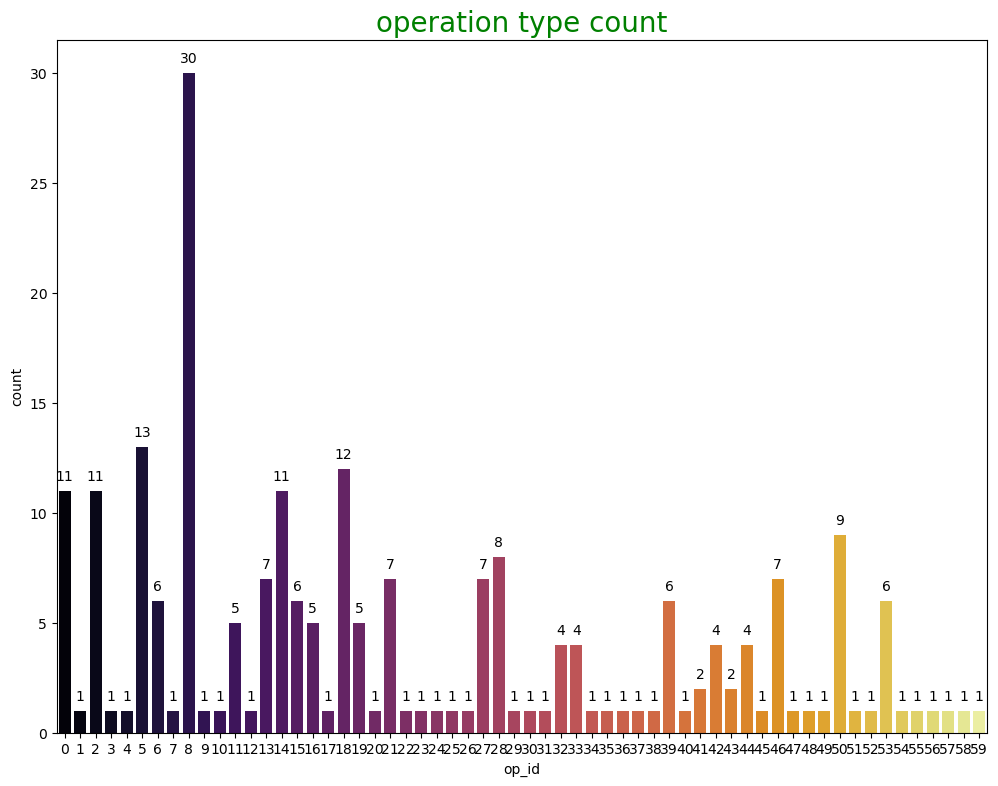

In [167]:
plt.figure(figsize=[12,9])
plot = sns.countplot(df["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
#plt.xticks(rotation=90)
plt.savefig("../../figures/class_and_count_initial.png", bbox_inches='tight')
plt.show()

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [168]:
df_drop_solo= df.groupby("op_id").filter(lambda x: len(x) >2)
df_drop_solo.to_excel("../../data/processed/corpora_unique_ops_dropped_wo_paraph.xlsx")
# Here paraphrase and import again
df_drop_solo = pd.read_excel("../../data/processed/train_test_only_paraphrased.xlsx")

In [169]:
df_drop_solo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     877 non-null    int64  
 1   Question       877 non-null    object 
 2   extents        877 non-null    object 
 3   upper level    131 non-null    object 
 4   timespan       45 non-null     object 
 5   Tag In Osm     401 non-null    object 
 6   Question type  877 non-null    object 
 7   ordinary1      877 non-null    object 
 8   ordinary2      835 non-null    object 
 9   ordinary3      670 non-null    object 
 10  ordinary4      375 non-null    object 
 11  ordinary5      181 non-null    object 
 12  ordinary6      59 non-null     object 
 13  ordinary7      34 non-null     object 
 14  ordinary8      0 non-null      float64
 15  ordinary9      0 non-null      float64
 16  ordinary10     0 non-null      float64
 17  ordinary103    0 non-null      float64
 18  ordinary10

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


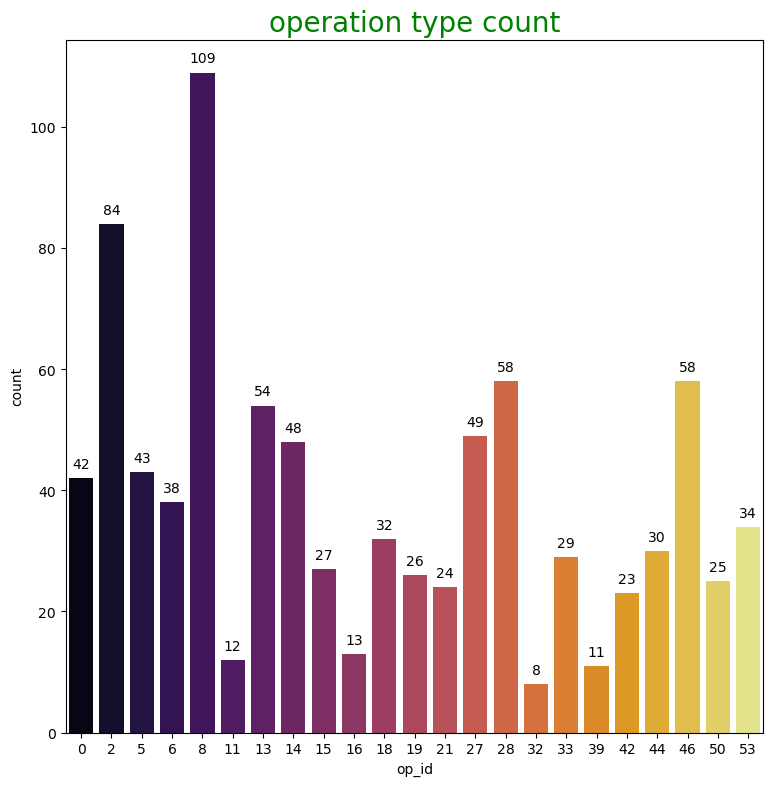

In [170]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig("../../figures/class_and_count_delete_unique_wo_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

In [171]:
tr_te_set = df_drop_solo
tr_te_set = tr_te_set.reset_index()
tr_te_set = tr_te_set.drop(columns=["index"])
print(tr_te_set)

     Unnamed: 0                                           Question  \
0             0             what areas are not wetlands in houston   
1             1    what is the land use in the happy valley resort   
2             2  how many luxury hotels are in happy valley ski...   
3             3  what is the number of luxury hotels in happy v...   
4             4   which visitor facilities are in the happy valley   
..          ...                                                ...   
872         872  Which houses have construction year between 19...   
873         873                   Which park is biggest in Utrecht   
874         874  Which schools are not accessible within 3 minu...   
875         875  Which schools are not within 3 minutes of driv...   
876         876  Which proposed wind farm are nearest to the hi...   

                     extents upper level timespan  \
0                    Houston         NaN      NaN   
1    the Happy Valley resort         NaN      NaN   


# 4. Preprocessing

In [172]:
questions = tr_te_set["Question"].str.lower()
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [173]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_org = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 58
print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


org:which suggested wind farm are nearest to the high way in scotland, 
lem:which suggest wind farm be near to the high way in scotland


## 4.2 Vectorize with TfIdf

In [174]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(877, 424)

# 5. classify

In [175]:
feature_names = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(features, columns = feature_names)
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question["for train"] = tr_te_set["for train"]
tfidf_w_question.to_excel("../../data/processed/tfidf_vectorized_paraphrase.xlsx")

In [176]:
Train_test_df = tfidf_w_question.drop(columns=["Question","processed_question"])
train_sample = Train_test_df[Train_test_df["for train"]==True]
X_train = train_sample.drop(columns=["for train"])
y_train = train_sample["op_id"]
test_sample = Train_test_df[Train_test_df["for train"]==False]
X_test = test_sample.drop(columns=["for train"])
y_test = test_sample["op_id"]

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

models = [
    LinearSVC(max_iter=300),
    MultinomialNB(),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=200),
    SVC(kernel='poly',
    max_iter=300)
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/small_classification_wo_paraphrase.png", bbox_inches='tight')
plt.show()

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.602645
LinearSVC                 0.965963
MLPClassifier             0.963526
MultinomialNB             0.379005
SVC                       0.430135
Name: accuracy, dtype: float64

# Pick model and run

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[13 50  6  6  8  8  8  8 53 53  8  8 19 19 19 19 46 46 44  8 39 39 14 14
 27 15 15  5  5 11  5  0  2  5 16 28 27 14 27 33  2 44  2 21  0 18 18 18
 53  0 21 50 50 13]
     actual
823      13
824      50
825       6
826       6
827       8
     predict
823       13
824       50
825        6
826        6
827        8
[0, 2, 5, 6, 8, 11, 13, 14, 15, 16, 18, 19, 21, 27, 28, 32, 33, 39, 42, 44, 46, 50, 53]


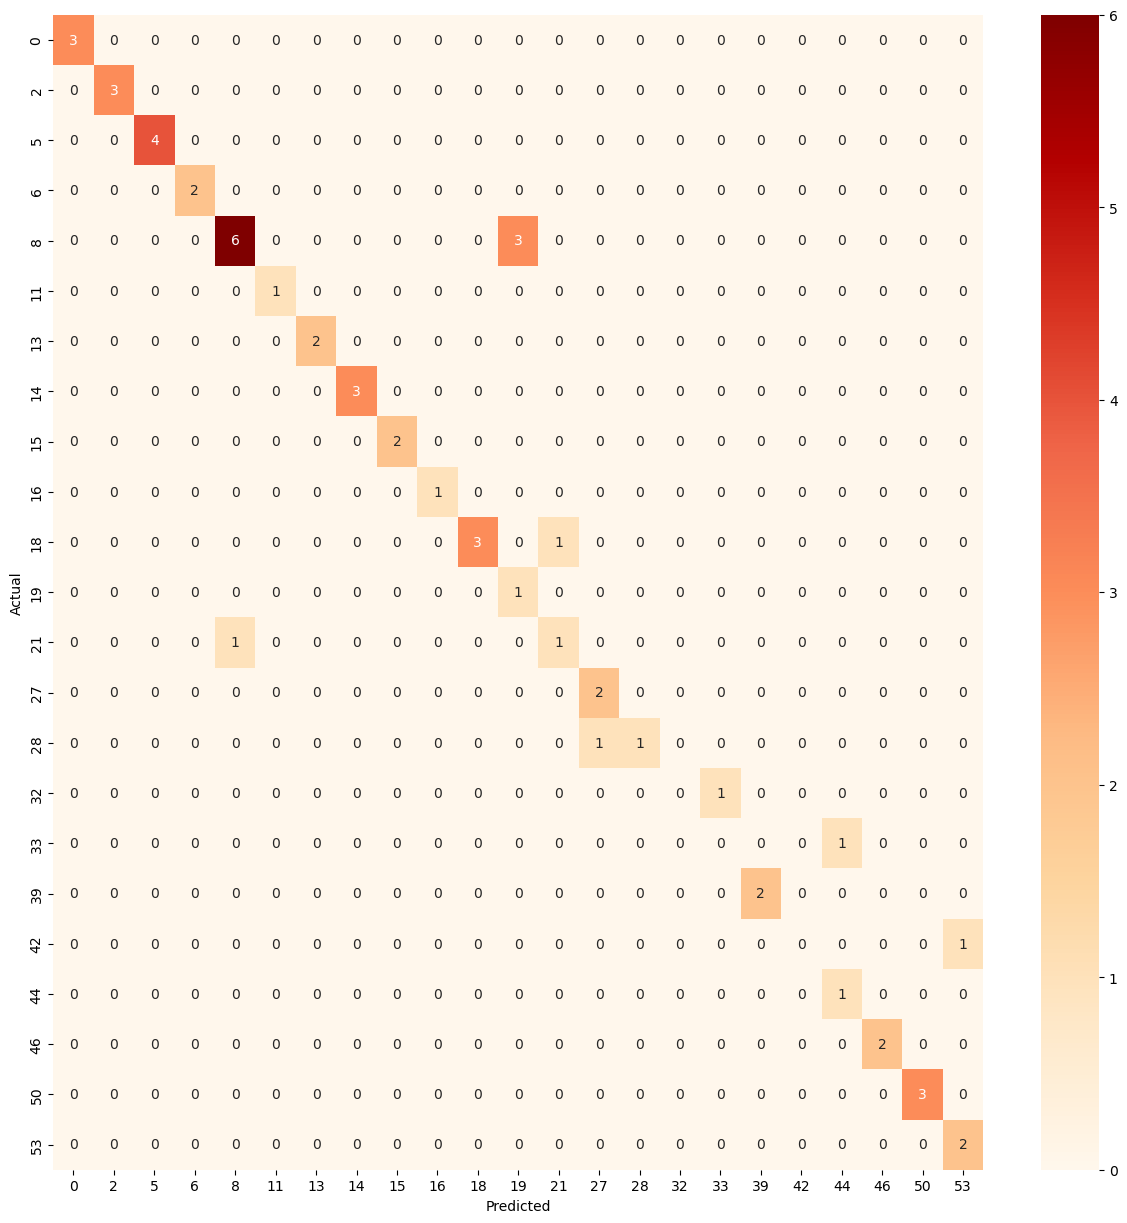

In [ ]:
model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

questions_df = tfidf_w_question.copy()
questions_df = questions_df.iloc[X_test.index,:]
questions_df = questions_df[["Question","processed_question","op_id"]]
y_test_df = y_test.to_frame(name="actual")
print(y_test_df.head(5))
y_pred_df = pd.DataFrame(y_pred,index=y_test.index,columns=["predict"])
print(y_pred_df.head(5))
questions_df["actual"] = y_test_df
questions_df["predict"] = y_pred_df
questions_df.to_excel("../../data/processed/prediction_vs_actual.xlsx")



from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_wo_paraphrase_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [ ]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_ = metrics.classification_report(y_test, y_pred, target_names=some_key)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("../../data/processed/classification_wo_paraphrase_report.xlsx")
print(report_)

['0', '2', '5', '6', '8', '11', '13', '14', '15', '16', '18', '19', '21', '27', '28', '32', '33', '39', '42', '44', '46', '50', '53']
accuracy 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           8       0.86      0.67      0.75         9
          11       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         1
          18       1.00      0.75      0.86         4
          19       0.25      1.00      0.40         1
          21       0.50      0.50      0.50         2
          27       0.67      1.00      0.80         2
          28       1.00    

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Visualize

In [ ]:
def plot_feature_effects(model, X_train,labels, feature_names):
    average_feature_effects = model.coef_ * np.asarray(X_train.mean(axis=0)).ravel()
    target_names = sorted(list(set(labels.values))) 
    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        top5 = top5.ravel()
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5),axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

        # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)
    ax.set_title("Average feature effect")
    fig.savefig("../../figures/avg_feagure_effect.png", bbox_inches='tight')

    return ax



_ = plot_feature_effects(model, X_train, labels, feature_names)

IndexError: index 424 is out of bounds for axis 0 with size 424

[    0   405   810  1215  1620  2025  2430  2835  3240  3645  4050  4455
  4860  5265  5670  6075  6480  6885  7290  7695  8100  8505  8910  9315
  9720 10125 10530 10935 11340 11745 12150 12555 12960 13365 13770 14175
 14580 14985 15390 15795 16200 16605 17010 17415 17820 18225 18630 19035
 19440 19845 20250 20655 21060 21465 21870 22275 22680 23085 23490 23895
 24300 24705 25110 25515 25920 26325 26730 27135 27540 27945 28350 28755
 29160 29565 29970 30375 30780 31185 31590 31995 32400 32805 33210 33615
 34020 34425 34830 35235 35640 36045 36450 36855 37260 37665 38070 38475
 38880 39285 39690 40095 40500 40905 41310 41715]
top 5 keywords per class:
           0          2          5        6        8        11        13  \
0  prefecture      total  euclidean    plain    unitl    crape   closest   
1       japan       auto   distance     belt     area   myrtle      wind   
2       aichi       sell    traffic    green   within  vacancy      farm   
3        park   montinye   pasadena 

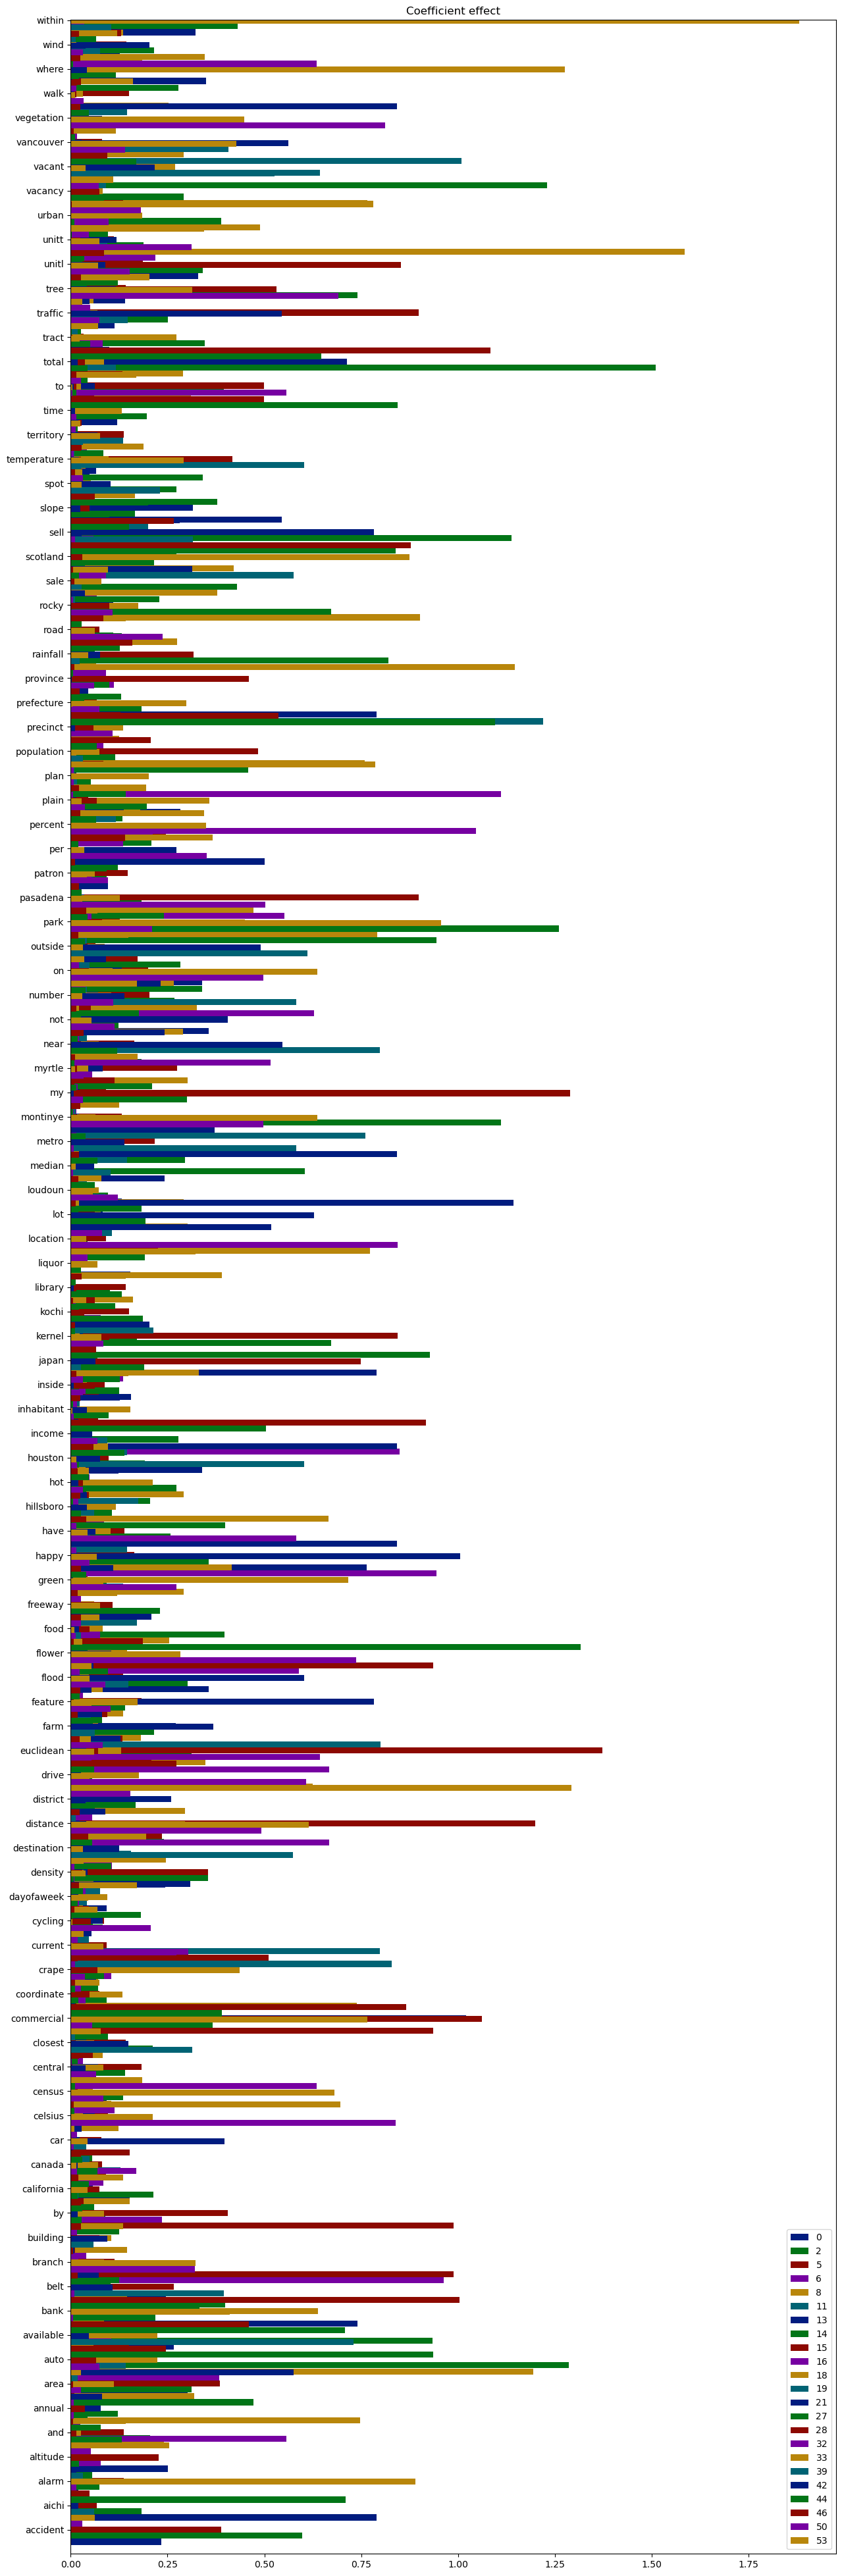

In [ ]:
def plot_coef_effects(model, X_train,labels, feature_names):
    coef_effects = np.absolute(model.coef_)
    target_names = sorted(list(set(labels.values))) 
    for i, label in enumerate(target_names):
        top5 = np.argsort(coef_effects[i])[-5:][::-1]
        top5 = top5.ravel()
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5),axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

        # plot feature effects
    bar_size = 100
    padding = 5
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)
    print(y_locs)

    fig, ax = plt.subplots(figsize=(15, 50))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            coef_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)
    ax.set_title("Coefficient effect")
    fig.savefig("../../figures/coef_effect.png", bbox_inches='tight')

    return ax



_ = plot_coef_effects(model, X_train, labels, feature_names)

(23, 351)


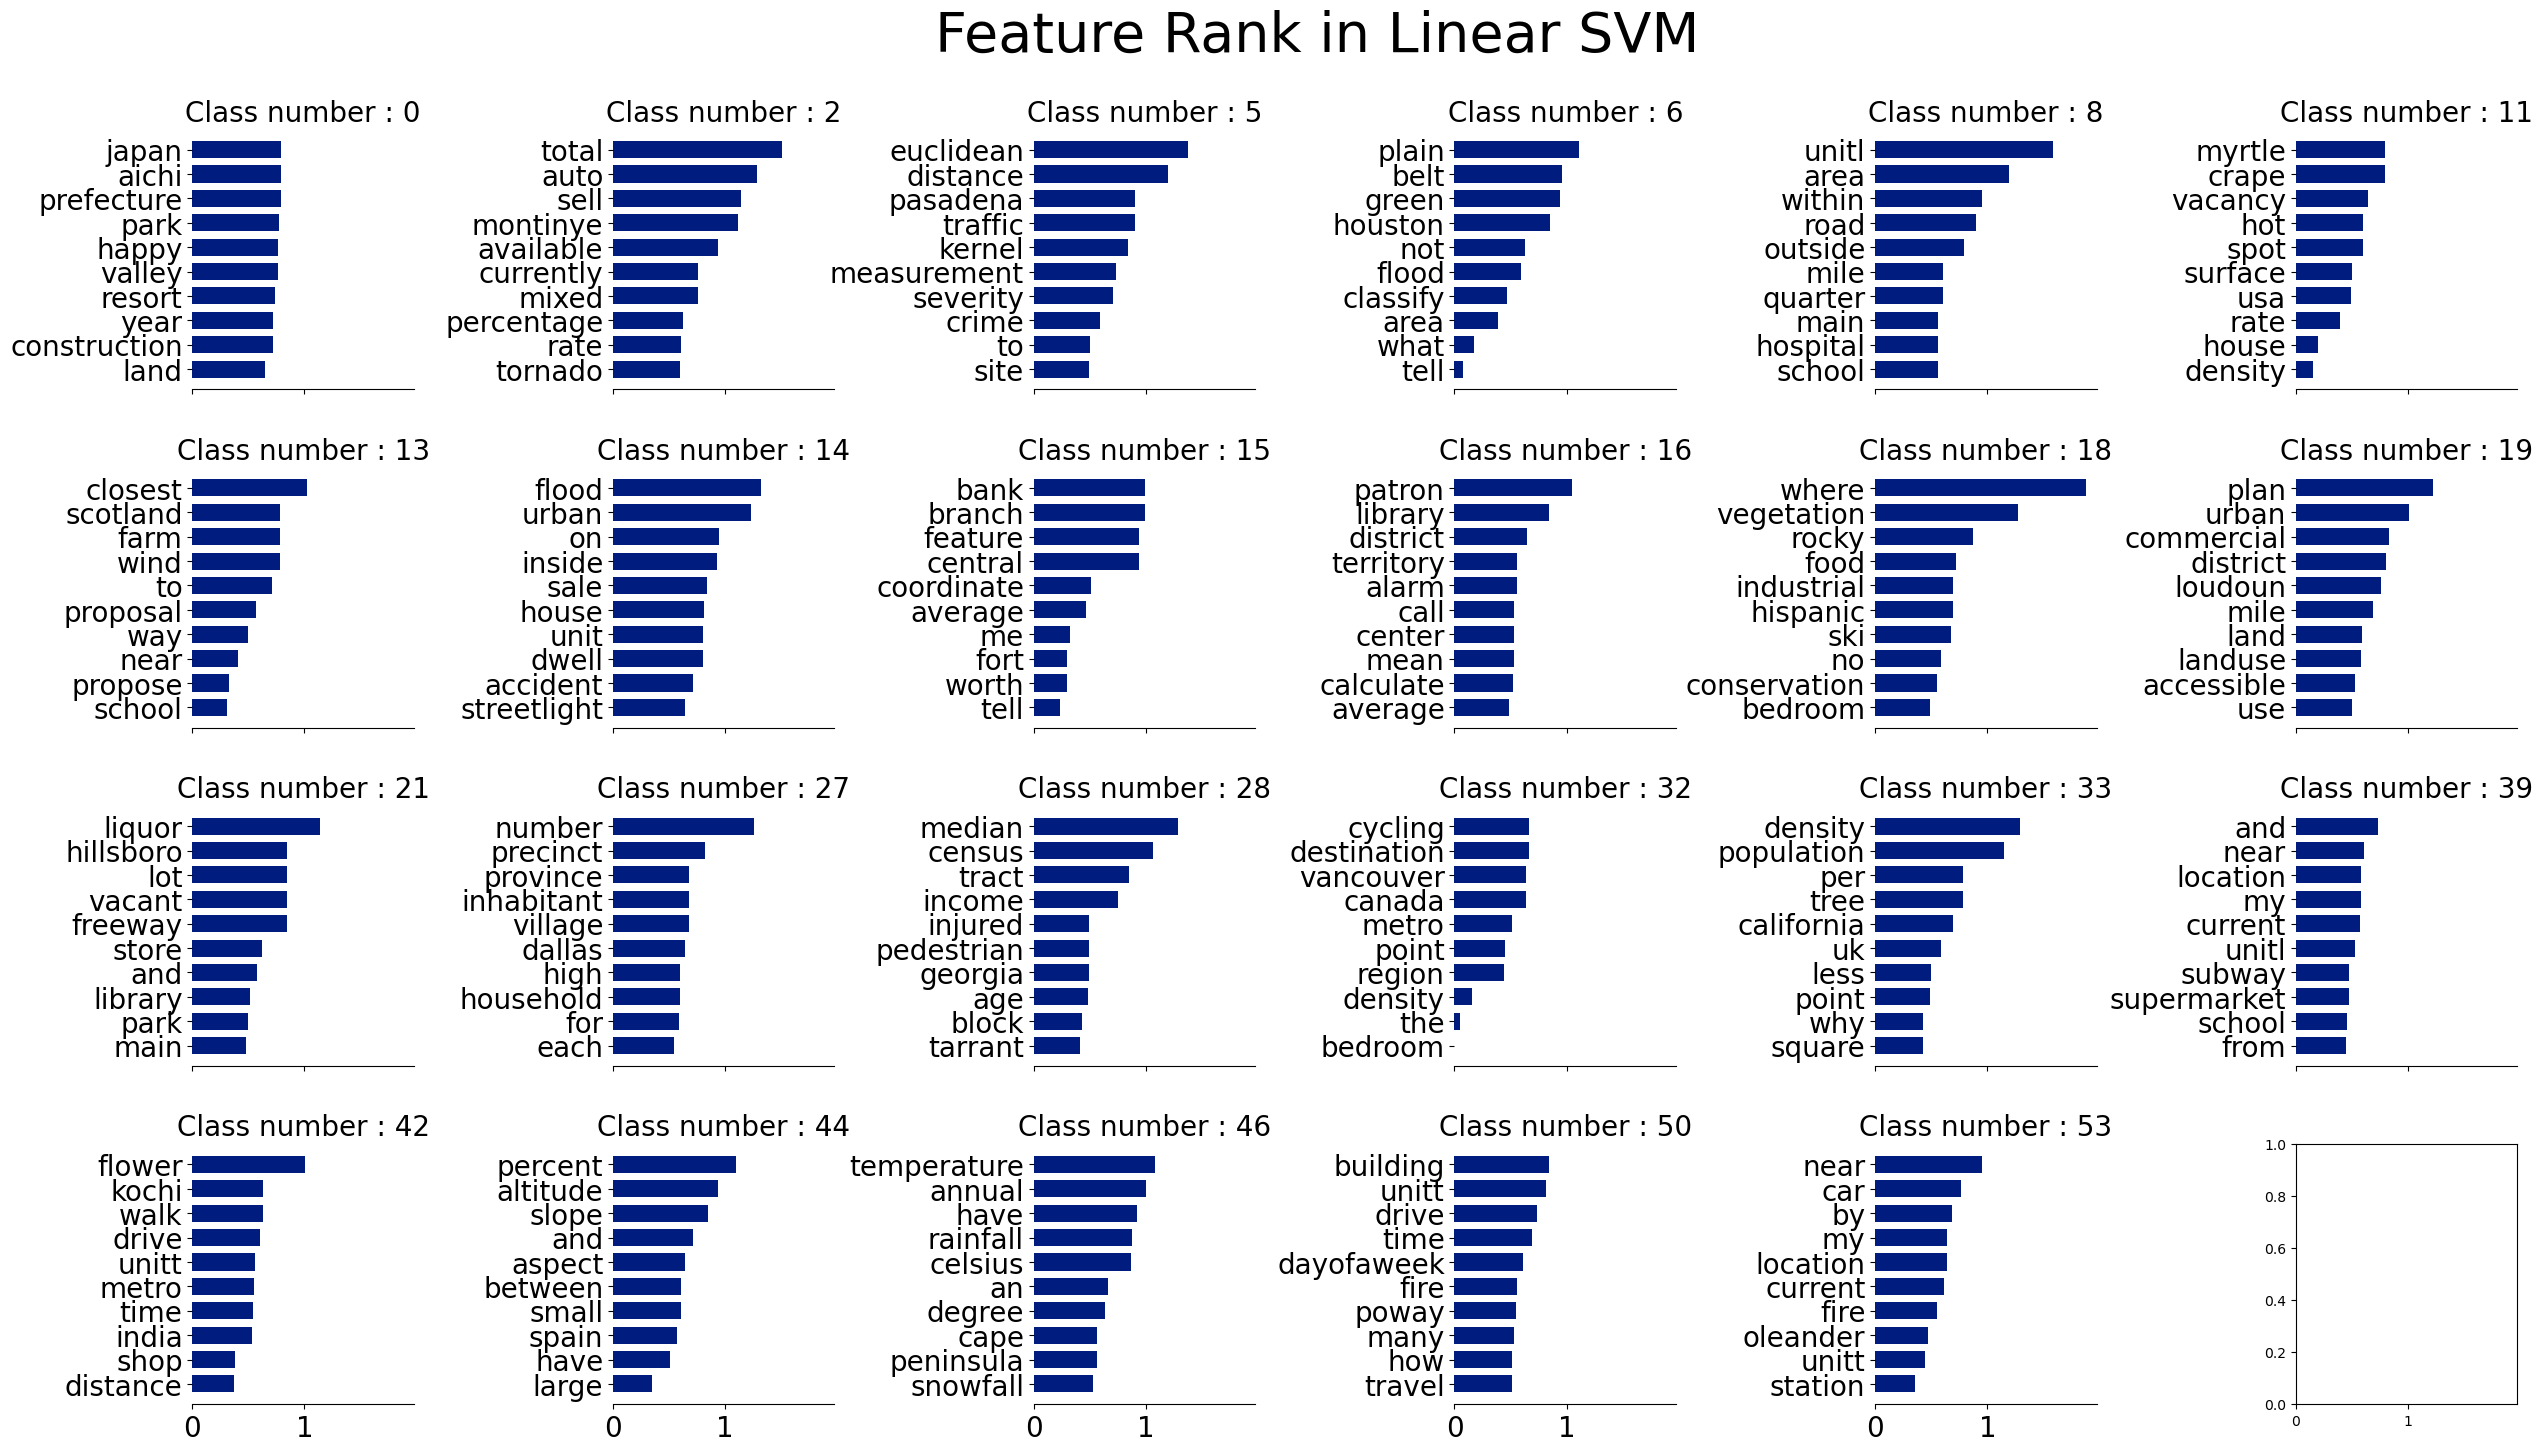

In [ ]:
def plot_top_words(isAbs, model, X_train,labels,n_top_words ,feature_names):
    fig_path = "../../figures/feature_rank_abs_in_linear_svm.png"
    coef_effects = np.absolute(model.coef_)
    if isAbs == False:
        fig_path = "../../figures/feature_rank_pos_in_linear_svm.png"
        coef_effects = model.coef_
    target_names = sorted(list(set(labels.values))) 
    plot_rows = 4
    fig, axes = plt.subplots(plot_rows, 
                             coef_effects.shape[0]//plot_rows if coef_effects.shape[0]%plot_rows == 0 else coef_effects.shape[0]//plot_rows + 1,
                              figsize=(30,15), sharex=True)
    axes = axes.flatten()
    print(coef_effects.shape)
    for topic_idx, topic in enumerate(coef_effects):
        top_features_ind = topic.argsort()[:-n_top_words-1:-1]
        top_features = feature_names[top_features_ind]
        class_number = target_names[topic_idx]
        coef_val = topic[top_features_ind]

        ax = axes[topic_idx] 
        ax.barh(top_features, coef_val, height=0.7)
        ax.set_title(f"Class number : {class_number}", fontdict={"fontsize":20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Feature Rank in Linear SVM", fontsize=40)
    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

    return 


_ = plot_top_words(isAbs=False,model=model, X_train= None,labels=labels, n_top_words=10, feature_names=feature_names)